# Notebook Description

This notebook is concerned with producing maps of the rainfall trends in the MJO phases (1-8) and the MJO subphases (enhanced, suppressed ect.).
<br>
This is done in the following order:
<ol>
    <li> AWAP and RMM data is loaded in. </li>
    <li> Data from start of year is moved to previous year, making resampling work for individual years.</li>
    <li> Data is split into different MJO phases (1-8). </li>
    <li> Indices (count and sum) are calculated for data. </li>
    <li> Phases are then compbined together to subphases.</li>
    <li> Trends then calculated for subphases.</li>
    
</ol>

# Packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
rb = plt.cm.RdBu
bm = plt.cm.Blues
best_blue = '#9bc2d5'
recherche_red = '#fbc4aa'
wondeful_white = '#f8f8f7'
import glob
import pdb

import warnings
warnings.filterwarnings('ignore')

import matplotlib.gridspec as gridspec

In [2]:
import sys
from importlib import reload
sys.path.append('')

# This is for loading in all the data sets that have been used in this study.
import load_dataset as load

# For splitting all of the data sets into the different phases.
import phase_calc_functions as phase_calc

# Collection of functions for plotting MJO phases.
import phase_plot_functions as phase_plot

# Collection of usefull functions. 
import miscellaneous as misc

In [3]:
image_dir = '../images/mjo_and_rainfall_trend_images/'

# Data

In [4]:
# Loading awap
awap = load.load_awap()

# Loading RMM
rmm = load.load_rmm()

# Making sure the two are the same length
awap = awap.where(awap.time.isin(rmm.time.values), drop = True)
rmm = rmm.where(rmm.time.isin(awap.time.values), drop = True)
len(awap.time.values), len(rmm.time.values)

(7876, 7876)

# Phase Splitting and Wet Season Calibration

Splitting into different MJO phases (1-8) and then moving the data from Jan-March back one year. The moving of the data back one year means that all of the data for an individual wet season is now with in the one year. This makes resampling much easier.

In [5]:
# Readjusting the years, so when a resample takes plact, it is just the data for one wet season. If 
# this was not done it would be the end half of one wet season and the start of another. This moves that data
# from the start of the wet season back or forwards a year (I don't remember), so that they line up

phase_calc = reload(phase_calc)
awap_ws = phase_calc.wet_season_year(awap)

rmm_ws = phase_calc.wet_season_year(rmm)

# Splitting AWAP into the the different phases of the Wheeler and Hendon MJO
awap_split_ws = phase_calc.split_into_1to8(awap_ws, rmm_ws)

In [6]:
awap_split_ws

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 9, time: 5199)
Coordinates:
  * time     (time) datetime64[ns] 1975-01-01 1975-01-02 ... 2018-12-31
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
Data variables:
    precip   (phase, time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    Information:  Only contains the wet season [10,11,12,1,2,3],rainfall >= 1...

## Extreme Filter

If extreme != 0, then this will make the data set only contain rainfall that is greater than the qth percentile.

In [7]:
extreme = 0
q = 95

In [8]:
# Below the file gets overrided into an extreme file, this is for emergencies
awap_split_ws_origonal = awap_split_ws.copy(deep = True)

In [9]:
awap_split_ws = awap_split_ws_origonal

In [10]:
# The same functions below apply for extreme rainfall. Just changing the rainfall to only extremes here.
# THe ex-piece adds on to the tile, so they don't get saved as the same name

if extreme:

    threshold = awap_split_ws.reduce(np.nanpercentile, dim = 'time', q = q)
    awap_split_ws = awap_split_ws.where(awap_split_ws.precip >= threshold.precip)
    ex_piece = f'{q}th_percentile'
else:
    ex_piece = ''

In [11]:
# Removign the points outside of a range that is too big
def max_filter(data, vmax):
    data = data.where(data.trend < vmax, vmax - 0.01)
    data = data.where(data.trend > -vmax, -vmax + 0.01)
    
    from miscellaneous import apply_masks
    data = apply_masks(data)
    
    return data

# Resampling

## Count

Counting the number of days in each year in each phase

In [12]:
# Resampling: getting the number of raindays each year (each year is a wet season).
awap_count = awap_split_ws.resample(time = 'y').count(dim = 'time')

# The index needs to be changed to just the year. Other wise it will be the full date.
awap_count['time'] = awap_count.time.dt.year
awap_count = awap_count.rename({'time':'year'})

For convecting the trend to subphases. They can be summed across the relevant phases.

In [14]:
awap_count_sub = phase_calc.resample_phase_to_subphase(awap_count)

In [15]:
awap_count_sub 

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 4, year: 44)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2014 2015 2016 2017 2018
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, year, lat, lon) int64 0 1 0 0 0 0 0 0 2 ... 0 0 0 0 0 0 0 0

## Sum

In [16]:
def awap_resample_sum(awap):
    awap_resampled = awap.resample(time = 'y').sum(dim = 'time')
    awap_resampled['time'] = awap_resampled.time.dt.year
    awap_resampled = awap_resampled.rename({'time':'year'})
    
    return awap_resampled

In [17]:
awap_sum = awap_resample_sum(awap_split_ws_origonal)

In [95]:
awap_sum

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 9, year: 44)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2014 2015 2016 2017 2018
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object '1' '2' '3' '4' '5' '6' '7' '8' 'inactive'
Data variables:
    precip   (year, phase, lat, lon) float32 0.0 2.688 10.36 ... 0.0 0.0 0.0

In [19]:
awap_sum_sub = phase_calc.resample_phase_to_subphase(awap_sum)

In [33]:
awap_sum_sub 

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, phase: 4, year: 44)
Coordinates:
  * year     (year) int64 1975 1976 1977 1978 1979 ... 2014 2015 2016 2017 2018
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (phase, year, lat, lon) float32 0.0 1.914 0.0 0.0 ... 0.0 0.0 0.0

In [88]:
def plot_hist(ax,data, phase, xmax = 700, step = 1, title = '', xlabel = ''):
    
    # Subsetting data.
    dist1 = data.isel(year = slice(0,21)).sel(
        phase = phase,lon = slice(110, 135), lat = slice(-25,-10)).precip.values.flatten()
    dist2 = data.isel(year = slice(22,43)).sel(
        phase = phase,lon = slice(110, 135), lat = slice(-25,-10)).precip.values.flatten()
    # Bins
    bins = np.arange(5,xmax,step)
    # First data slice
    ax.hist(dist1, bins = bins, color = recherche_red,
            alpha = 0.9, zorder = 0, label = '1975 to 1995'
    #         , density = True
            );
    # Second data slice
    ax.hist(dist2, bins = bins, 
             color = best_blue,alpha = 0.6,zorder = 1, label = '1996 to 2016'
    #         , density = True
            );
    # Xlims
    ax.set_xlim(5,xmax)
    # Legend
    leg = ax.legend(fontsize = 12)
    #Spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # Labels
    ax.set_ylabel('Frequency', size = 10);
    ax.set_xlabel(xlabel, size = 10);
    ax.set_title(title);

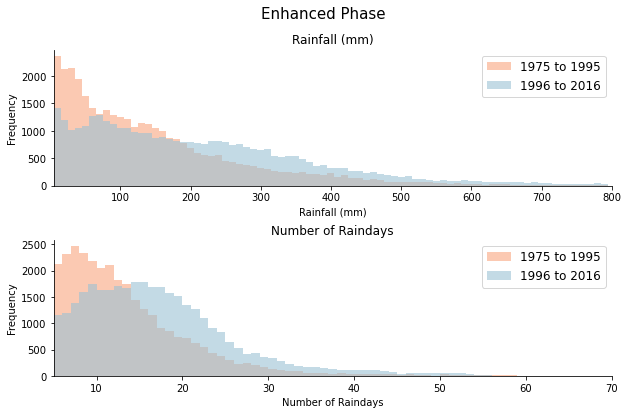

In [94]:
fig = plt.figure(figsize = (10,6))
gs = gridspec.GridSpec(2,1, hspace = 0.4)
phase = 'enhanced'

ax1 = fig.add_subplot(gs[0])
plot_hist(ax1,awap_sum_sub, phase, xmax = 800, step = 10,
          title = 'Rainfall (mm)', xlabel = 'Rainfall (mm)')

ax2 = fig.add_subplot(gs[1])
plot_hist(ax2,awap_count_sub, phase,xmax = 70, step = 1,
          title = 'Number of Raindays', xlabel = 'Number of Raindays')

fig.suptitle('{} Phase'.format(phase.capitalize()), fontsize = 15);
fig.savefig('../images/mjo_and_rainfall_trend_images/rainfall_enhanced_phase_pdf.png', dpi = 600)